In [55]:
import sys
import pandas as pd
import tensorflow.keras as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap

In [56]:
FILENAME = "healthcare-dataset-stroke-data.csv"
TEST_SIZE = 0.2
NUM_EVIDENCE = 15
EPOCHS = 20

# Data filtering
This section resolves issues with the healthcare stroke csv file and converts it into a list of evidence lists and a list of labels. Returns a tuple (evidence, labels)

In [57]:
def load_data():
    """
    Evidence should be a list of lists, where each list contains the following values, in order:
        - gender: 0 if "Male", 1 if "Female", 2 if "Other"
        - age: age of the patient in integer form
        - hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
        - heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
        - ever_married: 0 if "No", 1 if "Yes"
        - work_type: Split into the following multi-column attributes: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
        - Residence_type: 0 if "Rural", 1 if "Urban"
        - avg_glucose_level: average glucose level in blood in float form
        - bmi: body mass index in float form. values with NaN are replaced with the mean bmi
        - smoking_status: Split into the following multi-column attributes: "formerly smoked", "never smoked", "smokes" or "Unknown"

    labels should be the corresponding list of labels, where each label
    is 1 if patient has a stroke, and 0 otherwise.
    """
    df = pd.read_csv(FILENAME)
    # Remove columns not useful for prediction
    df = df.drop(columns=['id'])

    # Map columns into binary values
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
    df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
    df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})

    # Make multiple columns for multi-categorical attributes
    df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)
    df = df.astype({col: "int" for col in df.select_dtypes("bool").columns})

    # Replace all NaN fields with the average value of that column
    df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

    evidence = df.drop(columns='stroke')
    evidence.head()
    labels = df['stroke']
    labels.head()

    return evidence, labels

evidence, labels = load_data()
x_train, x_test, y_train, y_test = train_test_split(evidence, labels, test_size=TEST_SIZE)

# Neural Network Classification model
Constructs a neural network with an 8 unit hidden layer that outputs a value between 0 and 1 to determine if the patient has a stroke. Data is trained on a trained on 80% of the healtcare stroke dataset.

In [58]:
def create_model():
    """
    Costructs a neural network with an 8 unit hidden layer
    outputs a value between 0 and 1 to determine stroke
    """
    model = tf.models.Sequential()
    model.add(tf.layers.Dense(8, input_shape=(NUM_EVIDENCE,), activation="relu"))
    model.add(tf.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = create_model()
model.fit(x_train, y_train, epochs=EPOCHS)

/Users/gabeysinghe/Desktop/my projects/cs50/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.9318 - loss: 0.4638  
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.9467 - loss: 0.3170
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.9508 - loss: 0.2567
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.9521 - loss: 0.2201
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.9523 - loss: 0.2012
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.9523 - loss: 0.1892
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.9523 - loss: 0.1837
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.9521 - loss: 0.1796
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.9521 - loss: 0.1781
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9513 - loss: 0.1773
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.9513 - loss: 0.1772
Epoch 12/20
128/128 ━━━━━━━━

# Model Evaluation

In [59]:
y_pred_prob = model.predict(x_test, verbose=2)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("Accuracy: ", accuracy_score(y_test, y_pred))

32/32 - 0s - 1ms/step
Accuracy:  0.9432485322896281


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       968
           1       0.17      0.02      0.03        54

    accuracy                           0.94      1022
   macro avg       0.56      0.51      0.50      1022
weighted avg       0.91      0.94      0.92      1022



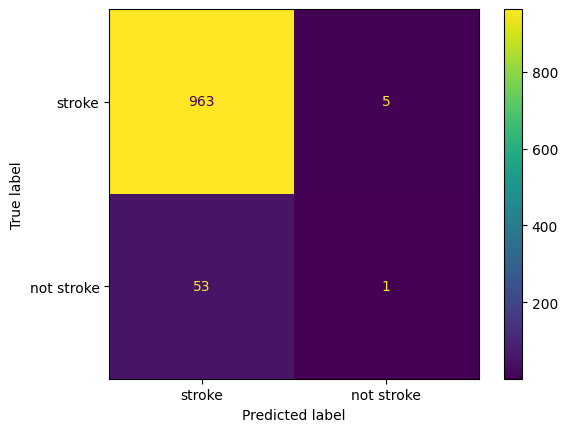

In [61]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['stroke', 'not stroke']))
disp.plot()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


  1%|          | 1/100 [00:00<00:10,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


  2%|▏         | 2/100 [00:00<00:10,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


  3%|▎         | 3/100 [00:00<00:10,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


  4%|▍         | 4/100 [00:00<00:10,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


  5%|▌         | 5/100 [00:00<00:10,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


  6%|▌         | 6/100 [00:00<00:10,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


  7%|▋         | 7/100 [00:00<00:10,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


  8%|▊         | 8/100 [00:00<00:09,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


  9%|▉         | 9/100 [00:00<00:09,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 10%|█         | 10/100 [00:01<00:09,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 11%|█         | 11/100 [00:01<00:09,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 12%|█▏        | 12/100 [00:01<00:09,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


 13%|█▎        | 13/100 [00:01<00:09,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 14%|█▍        | 14/100 [00:01<00:09,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


 15%|█▌        | 15/100 [00:01<00:09,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 16%|█▌        | 16/100 [00:01<00:09,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


 17%|█▋        | 17/100 [00:01<00:09,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 18%|█▊        | 18/100 [00:01<00:09,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 19%|█▉        | 19/100 [00:02<00:08,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


 20%|██        | 20/100 [00:02<00:08,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


 21%|██        | 21/100 [00:02<00:08,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 22%|██▏       | 22/100 [00:02<00:08,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


 23%|██▎       | 23/100 [00:02<00:08,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 24%|██▍       | 24/100 [00:02<00:08,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 25%|██▌       | 25/100 [00:02<00:08,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


 26%|██▌       | 26/100 [00:02<00:08,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


 27%|██▋       | 27/100 [00:02<00:08,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 28%|██▊       | 28/100 [00:03<00:07,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 29%|██▉       | 29/100 [00:03<00:07,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 30%|███       | 30/100 [00:03<00:07,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 31%|███       | 31/100 [00:03<00:07,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


 32%|███▏      | 32/100 [00:03<00:07,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


 33%|███▎      | 33/100 [00:03<00:07,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step


 34%|███▍      | 34/100 [00:03<00:07,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


 35%|███▌      | 35/100 [00:03<00:07,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


 36%|███▌      | 36/100 [00:03<00:06,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


 37%|███▋      | 37/100 [00:04<00:06,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


 38%|███▊      | 38/100 [00:04<00:06,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 39%|███▉      | 39/100 [00:04<00:06,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 40%|████      | 40/100 [00:04<00:06,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


 41%|████      | 41/100 [00:04<00:06,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


 42%|████▏     | 42/100 [00:04<00:06,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step


 43%|████▎     | 43/100 [00:04<00:06,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 44%|████▍     | 44/100 [00:04<00:05,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 45%|████▌     | 45/100 [00:04<00:05,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step


 46%|████▌     | 46/100 [00:04<00:05,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


 47%|████▋     | 47/100 [00:05<00:06,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


 48%|████▊     | 48/100 [00:05<00:05,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 49%|████▉     | 49/100 [00:05<00:05,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 50%|█████     | 50/100 [00:05<00:05,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


 51%|█████     | 51/100 [00:05<00:05,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 52%|█████▏    | 52/100 [00:05<00:05,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 53%|█████▎    | 53/100 [00:05<00:05,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


 54%|█████▍    | 54/100 [00:05<00:05,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 55%|█████▌    | 55/100 [00:06<00:05,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 56%|█████▌    | 56/100 [00:06<00:04,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 57%|█████▋    | 57/100 [00:06<00:04,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 58%|█████▊    | 58/100 [00:06<00:04,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 59%|█████▉    | 59/100 [00:06<00:04,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step


 60%|██████    | 60/100 [00:06<00:04,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 61%|██████    | 61/100 [00:06<00:04,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 62%|██████▏   | 62/100 [00:06<00:04,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 63%|██████▎   | 63/100 [00:06<00:04,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step


 64%|██████▍   | 64/100 [00:07<00:04,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 65%|██████▌   | 65/100 [00:07<00:04,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


 66%|██████▌   | 66/100 [00:07<00:03,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 67%|██████▋   | 67/100 [00:07<00:03,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 68%|██████▊   | 68/100 [00:07<00:03,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


 69%|██████▉   | 69/100 [00:07<00:03,  9.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 70%|███████   | 70/100 [00:07<00:03,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 71%|███████   | 71/100 [00:07<00:03,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 72%|███████▏  | 72/100 [00:07<00:03,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step


 73%|███████▎  | 73/100 [00:07<00:02,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


 74%|███████▍  | 74/100 [00:08<00:02,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


 75%|███████▌  | 75/100 [00:08<00:02,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


 76%|███████▌  | 76/100 [00:08<00:02,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step


 77%|███████▋  | 77/100 [00:08<00:02,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


 78%|███████▊  | 78/100 [00:08<00:02,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


 79%|███████▉  | 79/100 [00:08<00:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step


 80%|████████  | 80/100 [00:08<00:02,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


 81%|████████  | 81/100 [00:08<00:02,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


 82%|████████▏ | 82/100 [00:09<00:02,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


 83%|████████▎ | 83/100 [00:09<00:02,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


 84%|████████▍ | 84/100 [00:09<00:02,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


 85%|████████▌ | 85/100 [00:09<00:01,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


 86%|████████▌ | 86/100 [00:09<00:01,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 87%|████████▋ | 87/100 [00:09<00:01,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


 88%|████████▊ | 88/100 [00:09<00:01,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 89%|████████▉ | 89/100 [00:09<00:01,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 90%|█████████ | 90/100 [00:09<00:01,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step


 91%|█████████ | 91/100 [00:10<00:00,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


 92%|█████████▏| 92/100 [00:10<00:00,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


 93%|█████████▎| 93/100 [00:10<00:00,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step


 94%|█████████▍| 94/100 [00:10<00:00,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


 95%|█████████▌| 95/100 [00:10<00:00,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step


 96%|█████████▌| 96/100 [00:10<00:00,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step


 97%|█████████▋| 97/100 [00:10<00:00,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


 98%|█████████▊| 98/100 [00:10<00:00,  9.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step


 99%|█████████▉| 99/100 [00:10<00:00,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


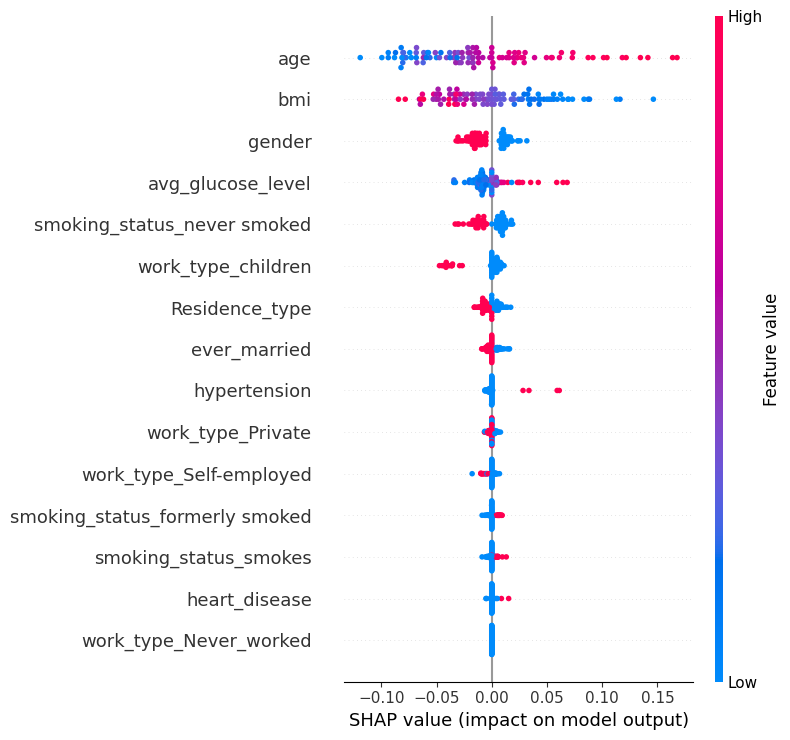

In [64]:
f = lambda x: model.predict(x).flatten()

background = x_train.sample(n=50, random_state=42)

explainer = shap.KernelExplainer(f, background.values)

shap_values = explainer.shap_values(x_test[:100], nsamples=100)

shap.summary_plot(shap_values, x_test[:100], feature_names=x_test.columns)